In [3]:

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pywt
import biosppy
import pandas as pd

def bandpassFilter(data):
    nyq = 0.5 * 360
    low = 3 / nyq
    high = 12 / nyq
    b, a = signal.butter(3, [low, high], btype='band')
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data


def pan_tompkins(ecg_data, fs=360, rel_amplitude=0.5, min_rr=120, max_rr=200):

    diff_data = np.diff(ecg_data)
    squared_data = diff_data**2

    # Moving average filter for smoothing
    window_size = int(0.02 * fs)  # Window size in samples (20 ms)
    average_data = np.convolve(squared_data, np.ones(window_size) / window_size, mode='same')

    # Thresholding
    high_threshold = rel_amplitude * np.max(average_data)
    low_threshold = 0.5 * high_threshold
    
    peaks = []

    # Iterate through data points
    
    for i in range(len(ecg_data)):
        if average_data[i] > high_threshold:
            peaks.append(i)
        if len(peaks) > 1 and i - peaks[-2] < min_rr:
            peaks.pop()
        elif len(peaks) > 2 and i - peaks[-1] > max_rr:
            peaks.pop()

    return np.array(peaks)

def preProcessing(fileName):
    
    with open(fileName, 'rb') as file:
        data = np.fromfile(file, dtype='int16')

    #correcting the baseline of the data

    corrected_data = signal.detrend(data)

    # creating a butter-worth filter or 2nd order
    # these are the best frequencie for this data

    cutoff_freq = 10
    sample_freq = 500 #Hz

    b, a = signal.butter(2, cutoff_freq / (sample_freq / 2))

    #filtering the signal

    filtered_data = signal.filtfilt(b, a, corrected_data)

    # applying wavelet transform on the baseline corrected data and then ignoring the high frequency and low frequency components
    arr = pywt.wavedec(corrected_data, 'sym4', level=4)

    # arr[0] = np.zeros_like(arr[0])
    arr[1] = np.zeros_like(arr[1])
    # arr[2] = np.zeros_like(arr[2])
    # arr[3] = np.zeros_like(arr[3])
    arr[4] = np.zeros_like(arr[4])

    wavdec_filtered_signal = pywt.waverec(arr, 'sym4')

    final_signal = bandpassFilter(wavdec_filtered_signal)

    results = biosppy.signals.ecg.christov_segmenter(signal=final_signal, sampling_rate=360)

    rTemp = results['rpeaks']
    
    r_peaks = [rTemp[0]]
    
    i = 1
    while i<len(rTemp):
        if rTemp[i]-300>rTemp[i-1]:
            r_peaks.append(rTemp[i])
        i += 1
        
    r_interval = [0]*(len(r_peaks)-1)

    for i in range(1, len(r_peaks)):
        r_interval[i-1] = r_peaks[i] - r_peaks[i-1]
        
    
    return r_interval


if __name__=="__main__":
    
    
#     normalN = 193
#     abnormalN = 40
    
# #     obtained from loop
#     min_normal = 17
#     min_abnormal = 18
    
#  So, it would be wise to make a table for 15 intervals

#     df = pd.DataFrame(columns=[f'x{i}' for i in range(15)] + ['y'])
    
#     for i in range(1, normalN+1):
        
#         filename = "Normal/"+str(i)+".dat"
#         data = preProcessing(filename)[0:15]
#         data.append(1)
#         df.loc[len(df)] = data
        
#     for i in range(1, abnormalN+1):
        
#         filename = "Abnormal/"+str(i)+".dat"
#         data = preProcessing(filename)[0:15]
#         data.append(0)   
#         df.loc[len(df)] = data
    
#     df.to_csv("final_dataframe.csv", index=False)
#     display(df)
    
    
#     mean = 0
    
#     for i in range(len(r_peaks)-1):
#         mean += r_peaks[i+1]-r_peaks[i]
        
#     mean /= (len(r_peaks)-1)
    
#     print(mean)
#     print(r_peaks[1]-r_peaks[0])

#     plt.figure(figsize=(13, 3))
#     plt.plot(final_signal)
#     plt.title("Filtered Signal using Wavelet decomposition")
#     plt.xlabel('samples')
#     plt.ylabel('amplitude')
#     plt.scatter(r_peaks, final_signal[r_peaks], c='red')
#     plt.grid(True)
# #     plt.ylim([-50, 150])
#     plt.tight_layout()

#     plt.show()
            
#     ca = 0
#     cn = 0
    
#     ma = 1e9
#     mn = 1e9
    
    
#     for i in range(na):
#         filename = "data/abnormal/"+str(i)+".dat"
#         arr = preProcessing(filename)
#         if(len(arr)<12):
#             ca += 1
#         ma = min(ma, len(arr))
        
    
#     for i in range(nn):
#         filename = "data/normal/"+str(i)+".dat"
#         arr = preProcessing(filename)
#         if(len(arr)<12):
#             cn += 1
#         mn = min(mn, len(arr))


    na = 109
    nn = 109
    
    threshold_len = 13
    
    #  So, it would be wise to make a table for 15 intervals

    df = pd.DataFrame(columns=[f'x{i}' for i in range(16)] + ['y'])
    
    for i in range(nn):
        
        filename = "mn bvormal/"+str(i)+".dat"
        data = preProcessing(filename)[0:16]
        if(len(data)>=15):
            data.append(1)
            df.loc[len(df)] = data
        
    for i in range(nn):
        
        filename = "data/abnormal/"+str(i)+".dat"
        data = preProcessing(filename)[0:16]
        if(len(data)>=15):
            data.append(0)
            df.loc[len(df)] = data
    
    df.to_csv("final_dataframe_equal.csv", index=False)
    display(df)
    
    


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,y
0,751,814,929,934,917,935,888,868,846,829,821,758,736,719,725,743,1
1,840,811,751,719,710,736,801,917,856,866,844,816,781,745,716,722,1
2,778,799,801,746,715,718,739,798,816,826,864,827,824,810,810,778,1
3,763,785,770,800,802,832,788,813,796,787,749,768,753,770,744,773,1
4,701,708,733,761,731,749,758,762,726,739,731,737,709,721,725,726,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,647,630,647,712,675,682,755,841,856,828,707,711,723,707,660,667,0
209,658,656,669,708,742,760,737,720,708,683,658,618,619,615,594,589,0
210,713,691,685,712,824,1314,1088,828,808,705,759,1228,1150,976,892,884,0
211,723,757,707,657,614,592,575,710,907,755,758,754,731,655,654,654,0


In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv("final_dataframe.csv")

display(data)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,y
0,751,814,929,934,917,935,888,868,846,829,821,758,736,719,725,1
1,840,811,751,719,710,736,801,917,856,866,844,816,781,745,716,1
2,778,799,801,746,715,718,739,798,816,826,864,827,824,810,810,1
3,763,785,770,800,802,832,788,813,796,787,749,768,753,770,744,1
4,701,708,733,761,731,749,758,762,726,739,731,737,709,721,725,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,1212,810,1200,968,895,893,1270,1009,900,1002,1117,881,952,1085,940,0
229,765,721,686,664,645,638,689,856,873,922,943,976,938,971,966,0
230,713,691,685,712,824,1314,1088,828,808,705,759,1228,1150,976,892,0
231,838,843,900,799,847,936,839,902,918,867,884,938,869,732,731,0


['N', 't', 'N', 't', 'N', 't', 'N', 't', 'N', 't', 'N', 't', 'N', 't', 'N', 't', 'N', 't', 'N', 't']
[[-0.215  0.02 ]
 [-0.15   0.015]
 [-0.16   0.005]
 ...
 [-0.025 -0.015]
 [ 0.01  -0.015]
 [ 0.035 -0.01 ]]


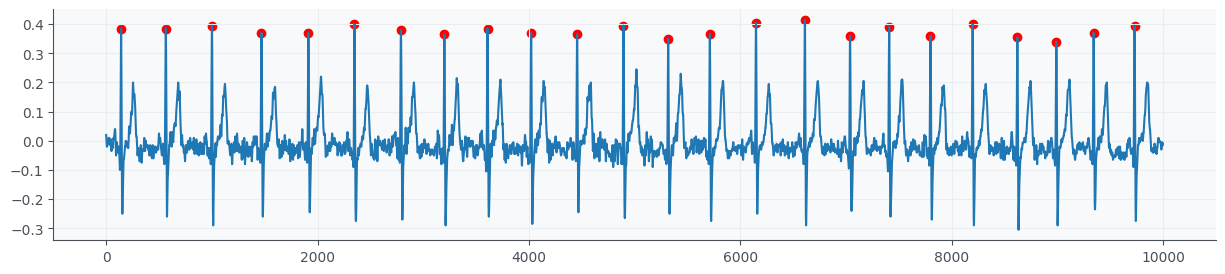

In [46]:
import wfdb
import matplotlib.pyplot as plt
from scipy import signal as sig
import pywt
import numpy as np


def bandpassFilter(data):
    nyq = 0.5 * 360
    low = 3 / nyq
    high = 12 / nyq
    b, a = sig.butter(3, [low, high], btype='band')
    filtered_data = sig.filtfilt(b, a, data)
    return filtered_data

def preProcessing(data):

    # creating a butter-worth filter or 2nd order
    # these are the best frequencie for this data

    cutoff_freq = 10
    sample_freq = 360 #Hz

#     final_signal = bandpassFilter(data)

    results = biosppy.signals.ecg.christov_segmenter(signal=data, sampling_rate=500)

    rTemp = results['rpeaks']
    
    r_peaks = [rTemp[0]]
    
    i = 1
    while i<len(rTemp):
        if rTemp[i]-300>rTemp[i-1]:
            r_peaks.append(rTemp[i])
        i += 1
        
#     r_interval = [0]*(len(r_peaks)-1)

#     for i in range(1, len(r_peaks)):
#         r_interval[i-1] = r_peaks[i] - r_peaks[i-1]
        
    
    return final_signal, r_peaks



print(wfdb.rdann("dataset/Person_02/rec_1", "atr").symbol)

print(wfdb.rdrecord("dataset/Person_02/rec_1").p_signal)


signal = wfdb.rdrecord("dataset/Person_02/rec_1").p_signal

data1 = np.zeros(len(signal))
data2 = np.zeros(len(signal))

for i in range(len(signal)):
    data1[i] = signal[i][1]
    data2[i] = signal[i][0]
    
final_signal, r_peaks = preProcessing(data1)

plt.figure(figsize=(15, 3))
plt.plot(data1)
plt.scatter(r_peaks, data1[r_peaks], color="red")
plt.show()


In [60]:
arr = wfdb.rdsamp("dataset/Person_01/rec_1", channels=[1])
wfdb.plotrec(arr)
print(arr.__dict__)

AttributeError: module 'wfdb' has no attribute 'plotrec'

ValueError: Input could not be cast to an at-least-1D NumPy array

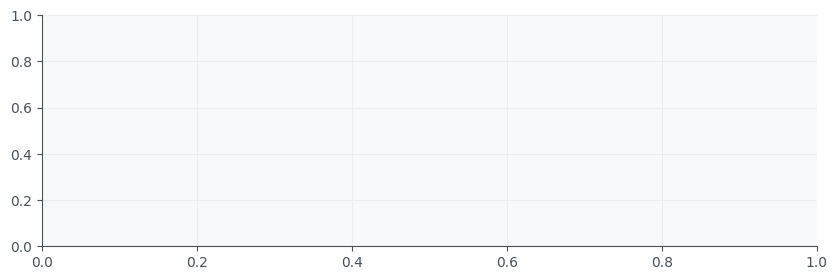

In [59]:
plt.figure(figsize=(10, 3))
plt.plot(arr)
plt.show()

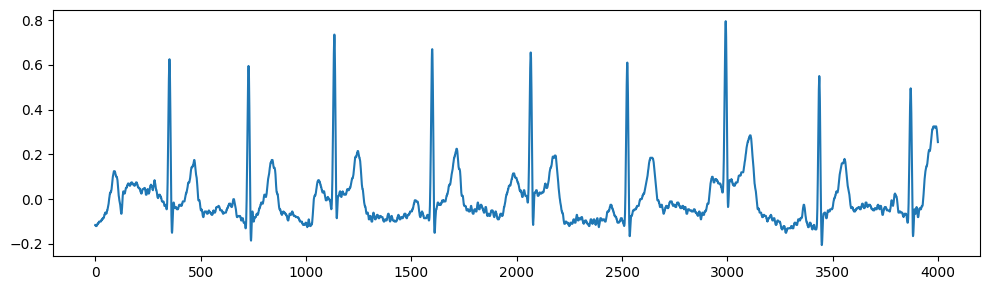

In [6]:
import wfdb
import matplotlib.pyplot as plt

signal = wfdb.rdrecord("dataset/Person_01/rec_1", channels=[1]).p_signal

plt.figure(figsize=(10, 3))
plt.plot(signal[:4000])
plt.tight_layout()
plt.show()